In [1]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

Импортируется датасет для классификации заболеваний картошки.

In [2]:
import kagglehub
path = kagglehub.dataset_download("mukaffimoin/potato-diseases-datasets")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/potato-diseases-datasets


## Подготовка данных


Создается класс датасет для создания тренировочнх и тестовых выборок, а также определения классов.

In [ ]:
class PotatoDiseasesDataset(Dataset):
    def __init__(self, dataset_dir: str) -> None:
        self.classes = (
            "Black Scurf",
            "Blackleg",
            "Common Scab",
            "Dry Rot",
            "Healthy Potatoes",
            "Miscellaneous",
            "Pink Rot"
        )
        self._dir: Path = Path(dataset_dir)
        self._files: list[Path] = []
        for file in self._dir.rglob("*"):
            if file.suffix not in [".jpeg", ".jpg", ".png"]:
                continue
            self._files.append(file)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self) -> int:
        return len(self._files)

    @property
    def num_classes(self):
        return len(self.classes)

    def __getitem__(self, idx: int) -> tuple:
        image = Image.open(self._files[idx]).convert("RGB")
        label = self._files[idx].parent.stem
        return self.transform(image), self.classes.index(label)

Разбиение на обучающую и тестовую выборки

In [ ]:
dataset_dir = f"{path}"
dataset = PotatoDiseasesDataset(dataset_dir)
trainset, testset = random_split(dataset, [0.8, 0.2])
print(len(trainset), len(testset))

361 90


Аугументация данных для улучшения бейзлайна

In [ ]:
trainset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=25),
    trainset.dataset.transform
])

Демонстрация содержимого датасетов.

In [6]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size = batch_size)

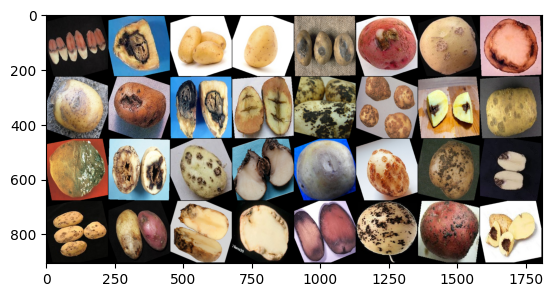

6 1 4 4 3 5 2 6 5 5 1 6 0 2 3 2 3 1 2 1 5 2 0 3 2 5 1 1 6 0 2 1


In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

## Обучение моделей классификации

Устанавливается девайс куда если есть

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Устанавливается количество эпох обучения. Так как датасет небольшой, эпох хватит 5

In [9]:
n_epochs = 5

Универсальная функция для обучения любых моделей. Вместе с обучением подсчитывается и метрики (accuracy и F1-score). Также определены функции для визуализации метрик с удобным форматом ввода данных и функция для определения оптимизатора и лоссса для любой модели.

In [10]:
def train(model, optimizer, epochs: int, n_print: int) -> tuple:
    train_accuracies = []
    train_f1_scores = []
    test_accuracies = []
    test_f1_scores = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        # Training phase
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        epoch_train_loss = running_loss / len(trainloader.dataset)
        epoch_train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
        epoch_train_f1 = f1_score(train_labels, train_preds, average='macro')

        train_accuracies.append(epoch_train_accuracy)
        train_f1_scores.append(epoch_train_f1)

        # Evaluation phase
        model.eval()
        test_preds = []
        test_labels = []
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                test_preds.extend(preds.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # Calculate test metrics
        epoch_test_accuracy = sum(1 for x, y in zip(test_preds, test_labels) if x == y) / len(test_labels)
        epoch_test_f1 = f1_score(test_labels, test_preds, average='macro')

        test_accuracies.append(epoch_test_accuracy)
        test_f1_scores.append(epoch_test_f1)

        # Print statistics
        if (epoch + 1) % n_print == 0:
            print(f"Epoch {epoch + 1}:")
            print(f"  Train Loss: {epoch_train_loss:.4f}")
            print(f"  Train Accuracy: {epoch_train_accuracy:.4f} | Train F1: {epoch_train_f1:.4f}")
            print(f"  Test Accuracy:  {epoch_test_accuracy:.4f} | Test F1:  {epoch_test_f1:.4f}")
            print("-" * 60)

    return (train_accuracies, train_f1_scores, test_accuracies, test_f1_scores)

def show_metrics(metrics_dict, metric_name="Accuracy", title="Model Comparison"):
    """
    Визуализирует метрики для нескольких моделей
    """
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", n_colors=len(metrics_dict)*2)

    for idx, (model_name, (train_metric, test_metric)) in enumerate(metrics_dict.items()):
        plt.plot(train_metric,
                 label=f'{model_name} - Train',
                 color=palette[idx*2],
                 linestyle='-',
                 linewidth=2)

        plt.plot(test_metric,
                 label=f'{model_name} - Test',
                 color=palette[idx*2+1],
                 linestyle='--',
                 linewidth=2)

    plt.title(f"{title} ({metric_name})", fontsize=14, pad=20)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()


def get_criterion_optimizer(model):
    return nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Модель реснет 18 является сверточной нейронной сетью.

In [11]:
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, dataset.num_classes)
model_resnet = model_resnet.to(device)
criterion, optimizer = get_criterion_optimizer(model_resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
train_acc_resnet, train_f1_resnet, test_acc_resnet, test_f1_resnet = train(model_resnet, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 1.8595
  Train Accuracy: 0.2632 | Train F1: 0.2562
  Test Accuracy:  0.4444 | Test F1:  0.3850
------------------------------------------------------------
Epoch 2:
  Train Loss: 1.3683
  Train Accuracy: 0.5429 | Train F1: 0.5215
  Test Accuracy:  0.6778 | Test F1:  0.6482
------------------------------------------------------------
Epoch 3:
  Train Loss: 0.9577
  Train Accuracy: 0.7396 | Train F1: 0.7355
  Test Accuracy:  0.7778 | Test F1:  0.7663
------------------------------------------------------------
Epoch 4:
  Train Loss: 0.7048
  Train Accuracy: 0.8504 | Train F1: 0.8478
  Test Accuracy:  0.7778 | Test F1:  0.7603
------------------------------------------------------------
Epoch 5:
  Train Loss: 0.6320
  Train Accuracy: 0.8006 | Train F1: 0.7972
  Test Accuracy:  0.8000 | Test F1:  0.7850
------------------------------------------------------------


Модель ViT является трансформерной нейросетью.

In [13]:
model_vit = torchvision.models.vit_b_16(pretrained=False, num_classes=dataset.num_classes)
pretrained_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
state_dict = pretrained_weights.get_state_dict(progress=True)
del state_dict['heads.head.weight']
del state_dict['heads.head.bias']
model_vit.load_state_dict(state_dict, strict=False)
model_vit = model_vit.to(device)
criterion, optimizer = get_criterion_optimizer(model_vit)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 149MB/s] 


In [14]:
train_acc_vit, train_f1_vit, test_acc_vit, test_f1_vit = train(model_vit, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 1.9083
  Train Accuracy: 0.2742 | Train F1: 0.1760
  Test Accuracy:  0.4444 | Test F1:  0.3883
------------------------------------------------------------
Epoch 2:
  Train Loss: 1.6579
  Train Accuracy: 0.5180 | Train F1: 0.4253
  Test Accuracy:  0.5333 | Test F1:  0.4851
------------------------------------------------------------
Epoch 3:
  Train Loss: 1.3207
  Train Accuracy: 0.6814 | Train F1: 0.6445
  Test Accuracy:  0.6222 | Test F1:  0.5870
------------------------------------------------------------
Epoch 4:
  Train Loss: 1.0278
  Train Accuracy: 0.7673 | Train F1: 0.7619
  Test Accuracy:  0.7778 | Test F1:  0.7582
------------------------------------------------------------
Epoch 5:
  Train Loss: 0.7991
  Train Accuracy: 0.8476 | Train F1: 0.8451
  Test Accuracy:  0.8111 | Test F1:  0.7918
------------------------------------------------------------


Самостоятельная имплементация многослойной модели со сверточной архитектурой.

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class CustomConvNet(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2)
        )
        self.res_block1 = ResidualBlock(32, 64)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2, 2)
        )
        self.res_block2 = ResidualBlock(128, 256)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(128, num_classes)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_block1(x)     # [B, 32, H/2, W/2]
        x = self.res_block1(x)      # [B, 64, H/2, W/2]
        x = self.conv_block2(x)     # [B, 128, H/4, W/4]
        x = self.res_block2(x)      # [B, 256, H/4, W/4]
        x = self.adaptive_pool(x)   # [B, 256, 4, 4]
        x = torch.flatten(x, 1)     # [B, 256*4*4]
        x = self.classifier(x)      # [B, num_classes]
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.normal_(m.bias, std=1e-6)

In [16]:
model_custom_conv = CustomConvNet(num_classes=dataset.num_classes).to(device)
# model_custom_conv = model_custom_conv
criterion, optimizer = get_criterion_optimizer(model_custom_conv)

In [17]:
train_custom_conv, train_f1_custom_conv, test_custom_conv, test_f1_custom_conv = train(model_custom_conv, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 2.1326
  Train Accuracy: 0.1967 | Train F1: 0.1797
  Test Accuracy:  0.2000 | Test F1:  0.0476
------------------------------------------------------------
Epoch 2:
  Train Loss: 1.5890
  Train Accuracy: 0.4155 | Train F1: 0.3690
  Test Accuracy:  0.2000 | Test F1:  0.1195
------------------------------------------------------------
Epoch 3:
  Train Loss: 1.3897
  Train Accuracy: 0.4460 | Train F1: 0.4190
  Test Accuracy:  0.3222 | Test F1:  0.2340
------------------------------------------------------------
Epoch 4:
  Train Loss: 1.3079
  Train Accuracy: 0.5069 | Train F1: 0.4845
  Test Accuracy:  0.3778 | Test F1:  0.2987
------------------------------------------------------------
Epoch 5:
  Train Loss: 1.2481
  Train Accuracy: 0.5125 | Train F1: 0.4956
  Test Accuracy:  0.4333 | Test F1:  0.3821
------------------------------------------------------------


Самостоятельная имплементация многослойной модели с трансформерной архитектурой.

In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim,
                            kernel_size=patch_size,
                            stride=patch_size)
        self.num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)  # [B, N, E]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embed
        return x

class CustomTransformer(nn.Module):
    def __init__(self, num_classes=7, embed_dim=160, depth=4,
                 num_heads=16, mlp_ratio=2.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(embed_dim=embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=0.1,
            activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=depth)
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.patch_embed.cls_token, std=0.02)
        nn.init.normal_(self.patch_embed.pos_embed, std=0.02)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        x = x[:, 0]
        return self.head(x)

In [19]:
model_custom_transformer = CustomTransformer()
model_custom_transformer = model_custom_transformer.to(device)
criterion, optimizer = get_criterion_optimizer(model_custom_transformer)

In [20]:
train_custom_transformer, train_f1_custom_transformer, test_custom_transformer, test_f1_custom_transformer = train(model_custom_transformer, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 1.9536
  Train Accuracy: 0.1801 | Train F1: 0.1149
  Test Accuracy:  0.1778 | Test F1:  0.0525
------------------------------------------------------------
Epoch 2:
  Train Loss: 1.9335
  Train Accuracy: 0.2050 | Train F1: 0.0996
  Test Accuracy:  0.2333 | Test F1:  0.0889
------------------------------------------------------------
Epoch 3:
  Train Loss: 1.9136
  Train Accuracy: 0.2632 | Train F1: 0.1363
  Test Accuracy:  0.2889 | Test F1:  0.1222
------------------------------------------------------------
Epoch 4:
  Train Loss: 1.8602
  Train Accuracy: 0.2465 | Train F1: 0.1534
  Test Accuracy:  0.2667 | Test F1:  0.1624
------------------------------------------------------------
Epoch 5:
  Train Loss: 1.8017
  Train Accuracy: 0.2992 | Train F1: 0.1822
  Test Accuracy:  0.3556 | Test F1:  0.1939
------------------------------------------------------------


Сравнение метрик

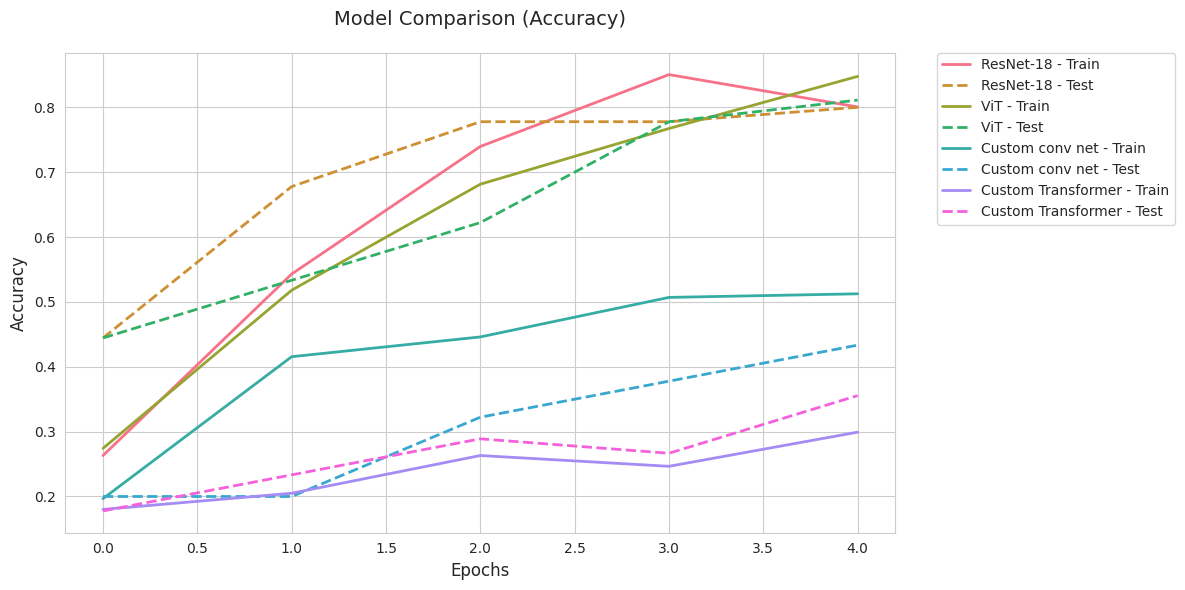

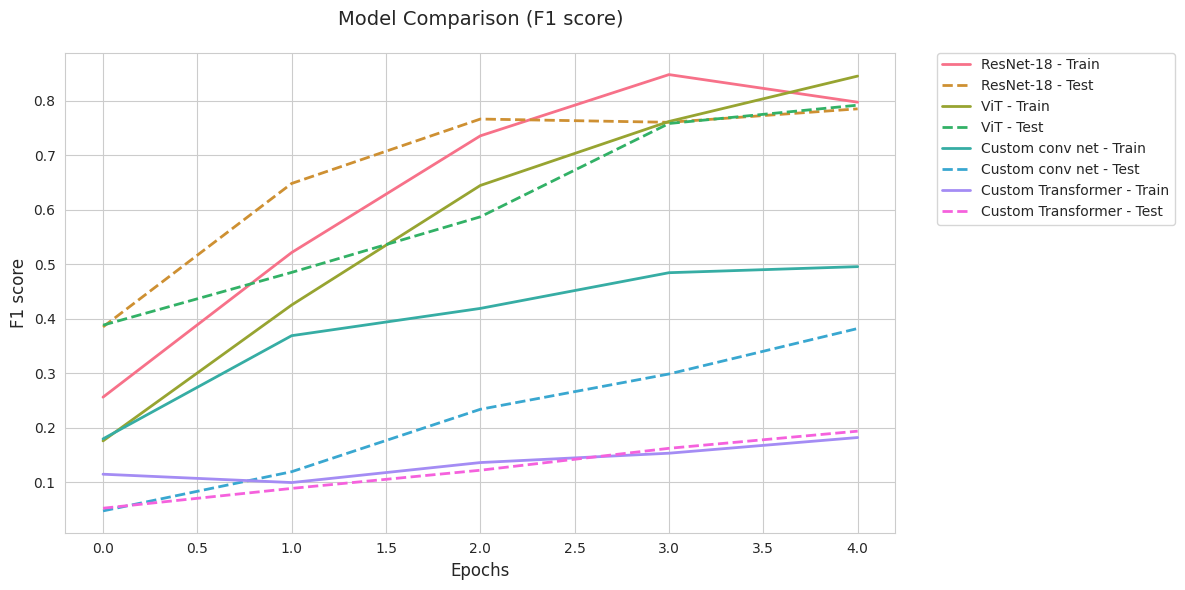

In [21]:
accuracy_data = {
    "ResNet-18": (train_acc_resnet, test_acc_resnet),
    "ViT": (train_acc_vit, test_acc_vit),
    "Custom conv net": (train_custom_conv, test_custom_conv),
    "Custom Transformer": (train_custom_transformer, test_custom_transformer)
}
f1_data = {
    "ResNet-18": (train_f1_resnet, test_f1_resnet),
    "ViT": (train_f1_vit, test_f1_vit),
    "Custom conv net": (train_f1_custom_conv, test_f1_custom_conv),
    "Custom Transformer": (train_f1_custom_transformer, test_f1_custom_transformer)
}
show_metrics(accuracy_data, metric_name="Accuracy")
show_metrics(f1_data, metric_name="F1 score")